<a href="https://colab.research.google.com/github/kurkur19/Analysis-BMD-Al-Khmuz-BS-25/blob/main/5_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%BE%D0%B1%D0%BE%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Аль Хмуз Карина БС-25 Практична робота №5

In [1]:
import numpy as np
from math import gcd

# Допоміжна функція: обернене число за модулем m (x^{-1} mod m)
def mod_inverse(a, m):
    a %= m
    if gcd(a, m) != 1:
        return None
    # розширений алгоритм Евкліда
    t0, t1 = 0, 1
    r0, r1 = m, a
    while r1 != 0:
        q = r0 // r1
        r0, r1 = r1, r0 - q * r1
        t0, t1 = t1, t0 - q * t1
    return t0 % m

# Інверсний конгруентний метод
# x_{n+1} = (a * x_n^{-1} + c) mod m
def inverse_congruential(n, seed, a, c, m):
    numbers = []
    x = seed % m
    if x == 0:
        x = 1   # гарантуємо ненульовий початковий стан

    for _ in range(n):
        inv = mod_inverse(x, m)
        # якщо обернене не існує (gcd(x, m) != 1) — трохи зсуваємо x
        while inv is None:
            x = (x + 1) % m
            if x == 0:
                x = 1
            inv = mod_inverse(x, m)

        x = (a * inv + c) % m
        if x == 0:
            x = 1   # уникнути нуля в послідовності
        numbers.append(x)

    return np.array(numbers)  # тут уже НЕ ділимо на m

# Параметри генерації
seed, a, c, m = 19, 26, 14, 100
n_warehouses = 3  # Кількість складів
n_stores = 5      # Кількість магазинів

# Генерація даних для складів (supply)
supply = inverse_congruential(n_warehouses, seed, a, c, m).astype(int)

# Генерація даних для магазинів (demand)
demand = inverse_congruential(n_stores, seed + 10, a, c, m).astype(int)

# Балансування попиту та постачання
total_supply = supply.sum()
total_demand = demand.sum()

if total_supply > total_demand:
    demand[0] += (total_supply - total_demand)  # Збільшуємо попит першого магазину
elif total_demand > total_supply:
    supply[0] += (total_demand - total_supply)  # Збільшуємо постачання першого складу

# Виведення результатів
print("Кількість товарів на складах (постачання):", supply)
print("Потреба магазинів (попит):", demand)


Кількість товарів на складах (постачання): [68 68 68]
Потреба магазинів (попит): [132  28   8  28   8]


In [2]:
import numpy as np
from geopy.distance import geodesic

# Геолокації складів
warehouses = [
    (50.394978, 30.422346),
    (50.569114, 30.488704),
    (50.546565, 30.700123)
]

# Геолокації магазинів
stores = [
    (50.449606, 30.522587),  # Магазин 1
    (50.440000, 30.520000),  # Магазин 2
    (50.460000, 30.510000),  # Магазин 3
    (50.470000, 30.500000),  # Магазин 4
    (50.480000, 30.490000)   # Магазин 5
]

# Функція для обчислення матриці відстаней
def calculate_distances(warehouses, stores):
    distances = np.zeros((len(warehouses), len(stores)), dtype=float)

    for i, w in enumerate(warehouses):
        for j, s in enumerate(stores):
            distances[i, j] = round(geodesic(w, s).km, 3)  # округлення до 3 знаків

    return distances

# Обчислення відстаней
distances = calculate_distances(warehouses, stores)

# Виведення результатів
print("Відстані від складів до магазину (км):")
for i, row in enumerate(distances, start=1):
    print(f"Склад {i}: {row}")


Відстані від складів до магазину (км):
Склад 1: [ 9.363  8.559  9.545 10.004 10.609]
Склад 2: [13.509 14.533 12.231 11.054  9.913]
Склад 3: [16.583 17.432 16.573 16.555 16.642]


In [3]:
from scipy.optimize import linprog
import numpy as np

# Матриця витрат (вартість перевезення пропорційна відстані)
# distances, supply, demand взяті з попередніх блоків
cost_matrix = distances

# Кількість складів і магазинів
n_sources, n_destinations = cost_matrix.shape

# Перевірка коректності розмірностей
assert n_sources == len(supply), "Кількість складів у cost_matrix і supply не збігається"
assert n_destinations == len(demand), "Кількість магазинів у cost_matrix і demand не збігається"

# Перевірка балансу задачі (сума постачання = сумі попиту)
total_supply = supply.sum()
total_demand = demand.sum()
assert total_supply == total_demand, "Транспортна задача не є закритою (∑supply ≠ ∑demand)"

# Формування коефіцієнтів цільової функції (вартість перевезення для кожного маршруту)
c = cost_matrix.flatten()

# Матриця обмежень та вектор правих частин
A_eq = np.zeros((n_sources + n_destinations, n_sources * n_destinations))
b_eq = np.concatenate([supply, demand])  # Спочатку постачання, потім попит

# Обмеження за постачанням (рядки складають фіксовану кількість)
for i in range(n_sources):
    A_eq[i, i * n_destinations:(i + 1) * n_destinations] = 1

# Обмеження за попитом (стовпці отримують потрібну кількість)
for j in range(n_destinations):
    A_eq[n_sources + j, j::n_destinations] = 1

# Межі для змінних: кількість перевезень не може бути від'ємною
bounds = [(0, None)] * (n_sources * n_destinations)

# Розв’язання задачі лінійного програмування
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# Перевірка результатів
if result.success:
    plan = result.x.reshape(n_sources, n_destinations)
    print("Оптимальний план перевезень (у штуках):")
    print(np.round(plan, 2))  # для виведення округляємо

    # Обчислюємо мінімальні сумарні транспортні витрати
    total_cost = float((plan * cost_matrix).sum())
    print(f"Мінімальні транспортні витрати: {total_cost:.3f} (умовних одиниць)")
else:
    print("Не вдалося знайти оптимальний план перевезень.")


Оптимальний план перевезень (у штуках):
[[40. 28.  0.  0.  0.]
 [24.  0.  8. 28.  8.]
 [68.  0.  0.  0.  0.]]
Мінімальні транспортні витрати: 2552.696 (умовних одиниць)


Карта збережена у файл transportation_plan.html


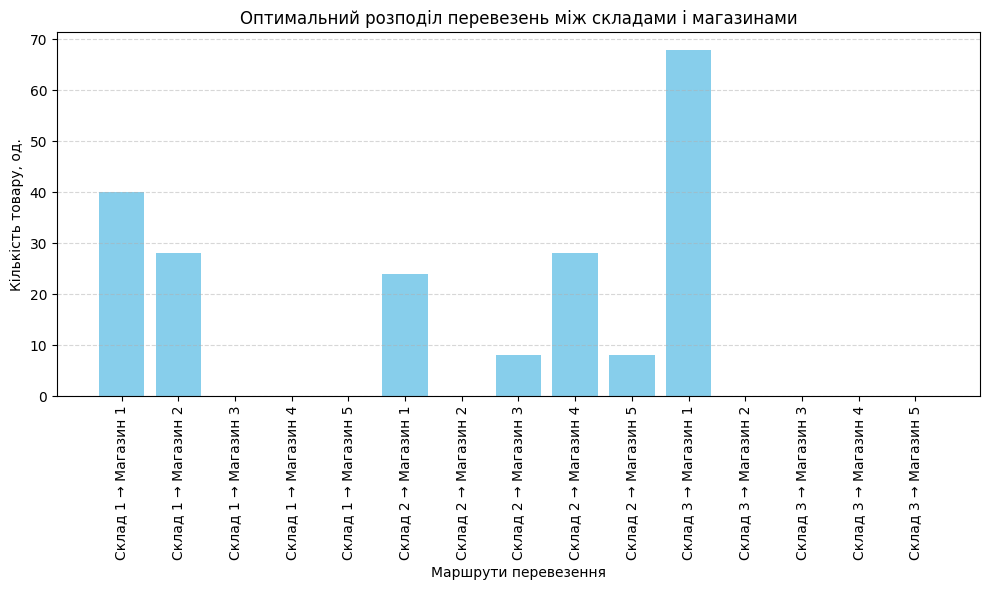

In [4]:
import matplotlib.pyplot as plt
import folium
import numpy as np

# Координати складів і магазинів
warehouses_coords = warehouses  # Склади
stores_coords = stores          # Магазини

# План перевезень (використовуємо вже знайдений plan з блоку з linprog)
plan = result.x.reshape(len(supply), len(demand))

# Створення карти
m = folium.Map(location=[stores_coords[0][0], stores_coords[0][1]], zoom_start=11)

# Додавання складів на карту
for i, warehouse in enumerate(warehouses_coords):
    folium.Marker(
        location=warehouse,
        popup=f"Склад {i+1}, запас: {int(supply[i])} од.",
        icon=folium.Icon(color="blue", icon="warehouse"),
    ).add_to(m)

# Додавання магазинів на карту
for i, store in enumerate(stores_coords):
    folium.Marker(
        location=store,
        popup=f"Магазин {i+1}, попит: {int(demand[i])} од.",
        icon=folium.Icon(color="red", icon="shopping-cart"),
    ).add_to(m)

# Масштабування товщини ліній, щоб виглядало адекватно
max_flow = plan.max() if plan.size > 0 else 0
min_width, max_width = 1, 8  # межі товщини лінії

def flow_to_width(x):
    if max_flow <= 0:
        return min_width
    return min_width + (max_width - min_width) * (x / max_flow)

# Додавання маршрутів перевезень
for i, warehouse in enumerate(warehouses_coords):
    for j, store in enumerate(stores_coords):
        flow = plan[i, j]
        if flow > 1e-6:  # малюємо тільки ненульові перевезення
            folium.PolyLine(
                locations=[warehouse, store],
                color="green",
                weight=flow_to_width(flow),
                tooltip=f"Склад {i+1} → Магазин {j+1}: {flow:.2f} од.",
            ).add_to(m)

# Збереження карти
m.save("transportation_plan.html")
print("Карта збережена у файл transportation_plan.html")

# Побудова графіка обсягів перевезень
plt.figure(figsize=(10, 6))

labels = [f"Склад {i+1} → Магазин {j+1}"
          for i in range(len(supply))
          for j in range(len(demand))]

values = plan.flatten()

plt.bar(labels, values, color='skyblue')
plt.title("Оптимальний розподіл перевезень між складами і магазинами")
plt.ylabel("Кількість товару, од.")
plt.xlabel("Маршрути перевезення")
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [7]:
from google.colab import files
files.download("transportation_plan.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>